# Mô tả bài toán
## Background

Dữ liệu địa chấn được thu thập bằng phản xạ địa chấn. Phương pháp này yêu cầu 1 nguồn địa chấn điều khiển được, như khí nén hoặc rung chấn, và sensor thu dữ liệu về các phản xạ từ những bề mặt đá ở lớp địa chất bên dưới. Dữ liệu này sẽ được xử lý để dựng lại môi trường 3 chiều dưới bề mặt Trái Đất.

Ảnh địa chấn thu được từ các phản xạ ở ranh giới giữa các loại đá. Nó cho biết thông tin về ranh giới nhưng không nhiều về bản thân tảng đá; một số loại đá có thể dễ dàng xác định được, một số thì khó. Về lý thuyết, độ mạnh của phản xạ tỉ lệ thuận trực tiếp với sự khác nhau về các thuộc tính vật lý giữa 2 bên đường ranh giới.

Có một số khu vực trên thế giới có lượng muối lớn ở dưới bề mặt, có một yêu cầu là xác định các vùng này từ ảnh địa chất. 
Muối có những tính chất:
* Khối lượng riêng thường là 2.14g/cc, thấp hơn hầu hết các loại đá xung quanh 
* Tốc độ địa chấn khi đi qua lớp muối là 4.5 km/s, thường nhanh hơn các loại đá xung quanh. Vận tốc cao này có thể gây ra các vấn đề cho ảnh địa chất.
=> sharp reflextion trên bề mặt lớp muối
* thường là đá vô định hình, nên muối có ít cấu trúc nội tại, do đó cũng có ít sự phản xạ tròng lòng lớp muối, trừ khi có cặn hay trầm tích.

## Data
Dữ liệu gồm một tập các sample:
Mỗi sample gồm: 
* 1 ảnh được chọn từ nhiều địa điểm ngẫu nhiên bên dưới bề mặt Trái Đất.
    * Kích thước: 101 x 101.
    * Mỗi pixel được phân vào 1 trong 2 lớp muối hoặc trầm tích được xác định bởi mask map.
    * Phần trên của ảnh tương ứng với phần địa chất gần mặt đất hơn. Cần lưu ý điều này khi augment data, tránh flip up down
* Độ sâu của vị trí được chọn

## Mục tiêu

Phân vùng (segment) khu vực chứa muối trên mỗi ảnh địa chất.

## Semantic image segmentation
Yêu cầu của contest này tương ứng với bài toán semantic image segmentation trong computer vision. Với input là một ảnh, mục tiêu là xác định label tương ứng với mỗi pixel trong ảnh đó.
<img src='https://www.jeremyjordan.me/content/images/2018/05/Screen-Shot-2018-05-16-at-9.36.38-PM.png' />

Trong bài toán này, sample trong training set thường gồm ảnh và segmentation map tương ứng:
* Mỗi ảnh được biểu diễn bởi 1 tensor 3 chiều kích thước `height×width×3` với ảnh màu hoặc `height×width×1` với ảnh xám
* Segmentation map biểu diễn label tương ứng với mỗi pixel trong ảnh đầu vào, label này được xác định bởi một số nguyên. Segmentation map có kích thước `height×width×1`.

Giống với bài toán classification, label của mỗi pixel có thể được encode bằng one hot encoding và thuật toán học sẽ cho ra một predict segmentation map $P$, kích thước ` height×widthxnum_class`, với $P_{i,j}$ biểu diễn xác suất của pixel $(i,j)$ ứng với mỗi class  
<img src="https://www.jeremyjordan.me/content/images/2018/05/Screen-Shot-2018-05-16-at-9.36.00-PM.png">

# Data Exploration

In [1]:
%load_ext autoreload
%autoreload 2

## Import

In [2]:
import os
os.chdir('../code')
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np

from utils.viz import plot_mask_on_img, plot_training_samples

root_ds = '../dataset'
img_size_ori = 101

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Sơ lược về dataset

Dữ liệu gồm 4000 training sample (image, mask) và 18000 test sample (chỉ có image). Mỗi sample được định danh bằng `id`. Toàn bộ `id` sẽ được cung cấp kèm với độ sâu tại tại vị trí của ảnh trong file `depths.csv`. `id` của các sample thuộc training set được cung cấp trong file `train.csv`, ngoài ra file này còn bao gồm `rle_mask` là mask map của sample đã được mã hóa bằng running length encoding.

In [4]:
depths_df = pd.read_csv(os.path.join(root_ds, "depths.csv"), index_col="id")
train_df = pd.read_csv(os.path.join(root_ds, "train.csv"), index_col="id", usecols=[0]) # bỏ cột rle_mask

In [5]:
depths_df.head()

,z
id,
4ac19fb269,306
1825fadf99,157
f59821d067,305
5b435fad9d,503
e340e7bfca,783


In [6]:
train_df.head()

""
id
2c45b152f1
3cb59a4fdc
e185ab5dc1
c78c89577c
6306dd3a8e


Từ `id` ta có thể load được sample tương ứng, các sample thuộc training set được lưu trong thư mục `train/images` và `train/masks`, các sample thuộc test set được lưu trong thư mục `test/images`

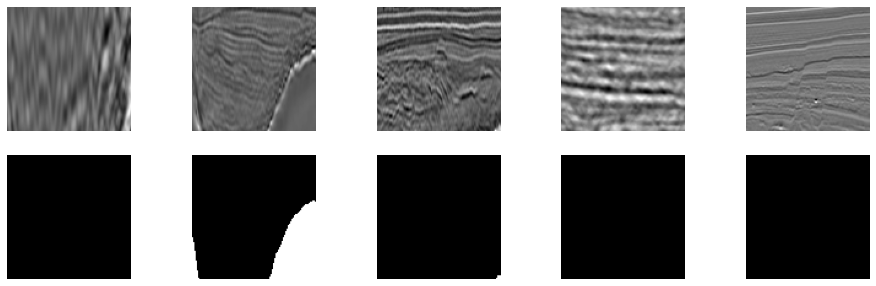

In [8]:
ids= ['1f1cc6b3a4','5b7c160d0d','6c40978ddf','7dfdf6eeb8','7e5a6e5013']
imgs = [np.array(Image.open(os.path.join(root_ds, 'train/images/' + img_name + '.png'))) for img_name in ids]
masks = [np.array(Image.open(os.path.join(root_ds, 'train/masks/' + img_name + '.png'))) for img_name in ids]
plot_training_samples(imgs, masks)

Plot mask trên ảnh tương ứng

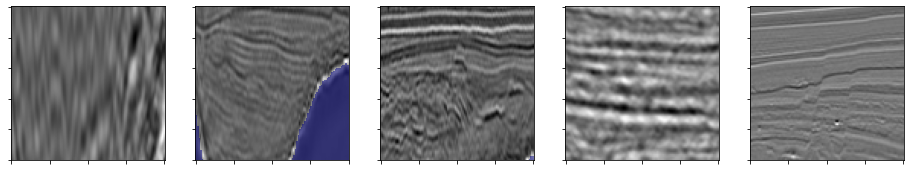

In [10]:
ids= ['1f1cc6b3a4','5b7c160d0d','6c40978ddf','7dfdf6eeb8','7e5a6e5013']
plot_training_samples(imgs, masks, mask_over_image=True)

## Thực hiện một số phép thống kê trên dataset

In [11]:
test_df = depths_df[~depths_df.index.isin(train_df.index)]
train_df = train_df.merge(depths_df, on='id')

Chuẩn bị sample:
* Load ảnh và masks
* Tính độ phủ của muối trong ảnh ứng với mỗi sample

In [12]:
train_df["images"] = [np.array(Image.open(os.path.join(root_ds, "train/images/{}.png".format(idx))), dtype=np.uint8) / 255 for idx in tqdm(train_df.index)]
train_df["masks"] = [np.array(Image.open(os.path.join(root_ds, "train/masks/{}.png".format(idx))), dtype=np.uint8) / 255 for idx in tqdm(train_df.index)]
train_df["coverage"] = train_df.masks.map(lambda x: np.sum(x) / pow(img_size_ori, 2))
def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [13]:
def plot_coverage(df, suptitle="Salt coverage"):
    fig, axs = plt.subplots(1, 3, figsize=(20,5))
    sns.histplot(df.coverage, kde=False, ax=axs[0])
    sns.histplot(df.coverage_class, bins=10, kde=False, ax=axs[1])
    plt.suptitle(suptitle)
    axs[0].set_xlabel("Coverage")
    axs[1].set_xlabel("Coverage class")
    axs[2].scatter(df.coverage, df.coverage_class)
    axs[2].set_xlabel("Coverage")
    axs[2].set_ylabel("Coverage class")

### 1. Plot histogram density của mask map trong training set
* Biểu đồ 1: Độ bao phủ của muối trong ảnh
* Biểu đồ 2: Phân mỗi sample vào class tương ứng với độ phủ
    * 0% - class 0
    * 0% < x <= 10% - class 1
    * ...
* Biểu đồ 3: Phân bố của độ phủ trên mỗi class

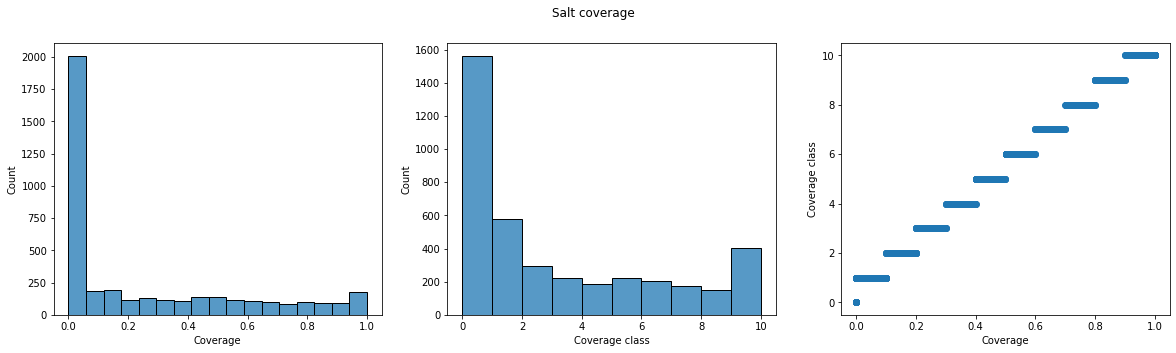

In [16]:
plot_coverage(train_df)

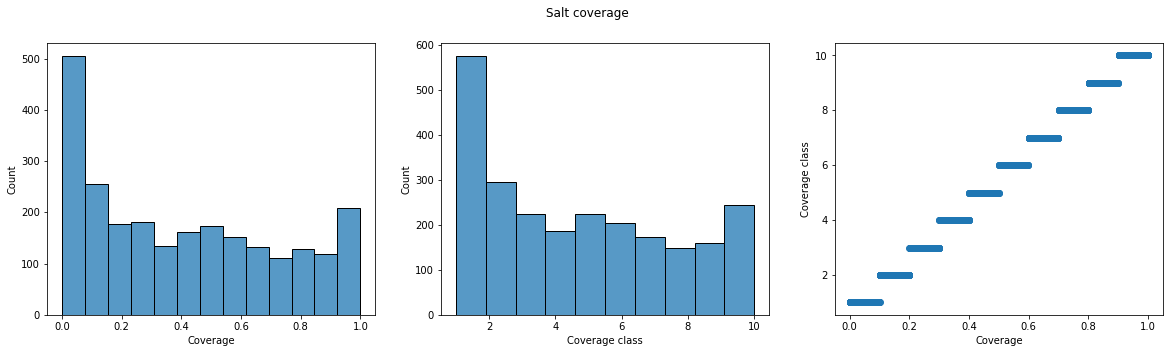

In [15]:
plot_coverage(train_df[train_df.coverage_class != 0])

Nhận xét:
* có lượng lớn sample trong training set không có muối trong ảnh

<AxesSubplot:xlabel='coverage', ylabel='Count'>

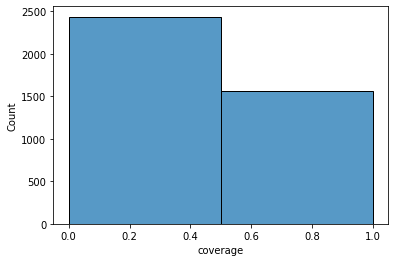

In [13]:
sns.histplot(train_df.coverage == 0, kde=False, bins=2)

* Với các class độ phủ còn lại phân bố của class 1 nhiều, còn lại tương đối đều

### 2. Plot phân bố độ sâu của các sample

Text(0.5, 0.98, 'Depth distribution')

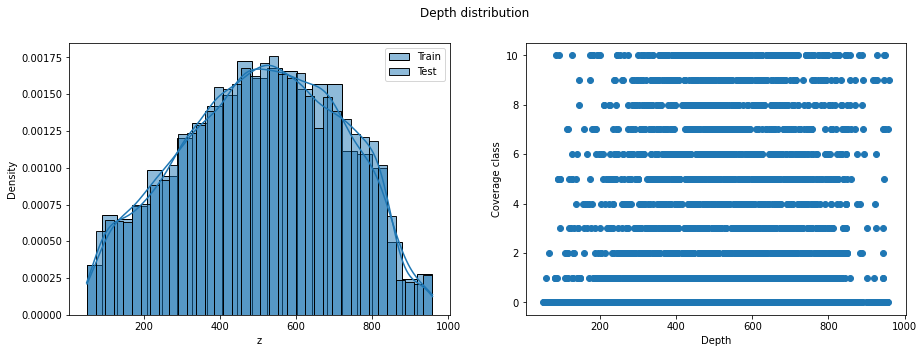

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(train_df.z, label="Train", kde=True, stat='density', ax=axs[0])
sns.histplot(test_df.z, label="Test", kde=True, stat='density', ax=axs[0])
axs[0].legend()

axs[1].scatter(train_df.z, train_df.coverage_class)
axs[1].set_xlabel("Depth")
axs[1].set_ylabel("Coverage class")

plt.suptitle("Depth distribution")

* Biểu đồ 1: Phân bố của depth trong training set và test set. Có thể thấy 2 phân bố này khá tương đồng. Ta kì vọng training set có khả năng biểu diễn tốt cho test set
* Biểu đồ 2: Phân bố của depth ứng với mỗi coverage class. Có thể thấy phân bố này tương đối đều và tương đồng giữa các class. Khả năng rằng thông tin về độ sâu không cung cấp nhiều thông tin về độ phủ.

## Show some example images

Sắp xếp lại training sample theo độ sâu sau đó plot các sample tương ứng với từng khoảng độ sâu.
Sample được plot kèm các thông tin:
* Góc trái trên: Coverage Class
* Góc phải trên: độ phủ
* Góc trái dưới: độ sâu

In [15]:
train_df = train_df.sort_values('z').reset_index()

In [16]:
def plot_images(start, step, max_images=60):
    grid_width = 10
    grid_height = int(max_images / grid_width)
    fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width * 2, grid_height * 2))
    for i in range(max_images):
        idx = i * step + start
        img = train_df.loc[idx].images
        mask = train_df.loc[idx].masks > 0
        ax = axs[int(i / grid_width), i % grid_width]
        plot_mask_on_img(ax, img, mask, train_df.loc[idx])
    plt.suptitle("Green: salt. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

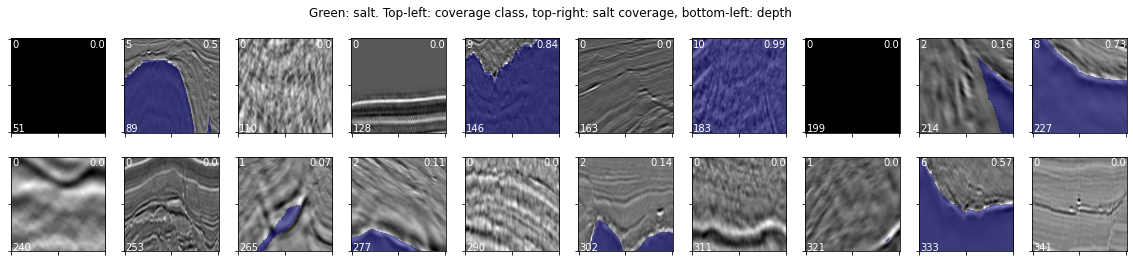

In [17]:
plot_images(0, 50, 20)

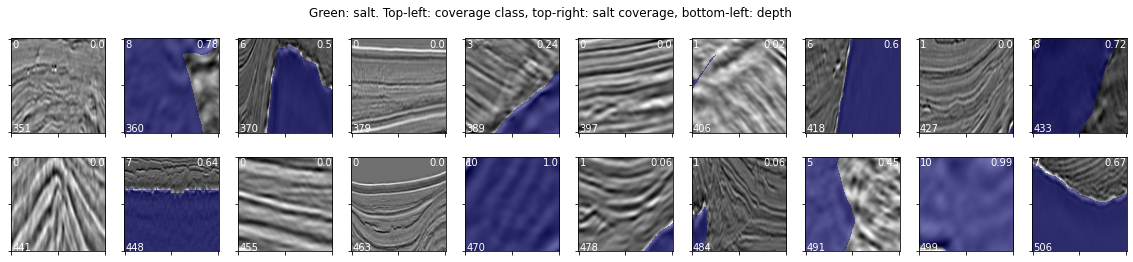

In [18]:
plot_images(1000, 50, 20)

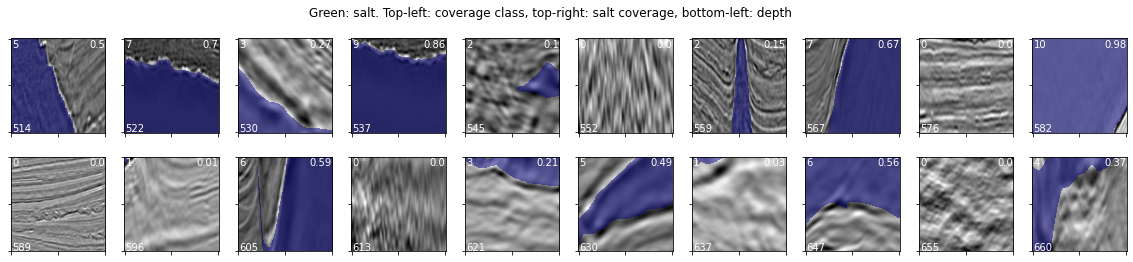

In [19]:
plot_images(2000, 50, 20)

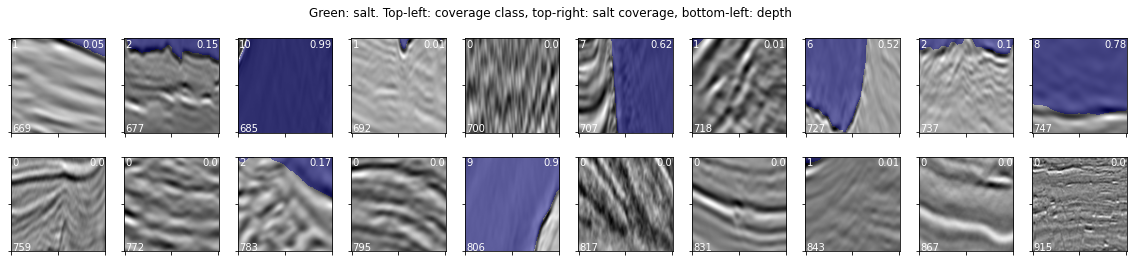

In [20]:
plot_images(3000, 50, 20)

## Thống kê trên mỗi fold
Thực hiện chia fold cho cross validation và làm một số phép thống kê trên mỗi fold để chắc chắn sự tương đồng giữa các fold.

In [21]:
from data.functional import generate_fold
generate_fold('../dataset', 5, '../dataset/folds.csv')

In [22]:
# Load bảng chia folds
folds_df = pd.read_csv(os.path.join(root_ds, "folds.csv"), index_col="id")
folds_df.head()

,z,fold,unique_pixels
id,,,
1c0b2ceb2f,71,0,1
16bee00afc,409,3,214
e82162c83c,884,3,240
97e78a5448,694,1,211
2edf2e3e05,439,3,135


Chú tích các cột:
* id: id của sample
* z: độ sâu
* fold: fold id tương ứng của sample
* unique_pixels: số giá trị khác nhau của các pixel trong ảnh

In [23]:
train_df = train_df.merge(folds_df.drop('z', axis=1), on='id')

In [24]:
train_df.head(1)

,id,z,images,masks,coverage,coverage_class,fold,unique_pixels
0,d0244d6c38,51,"[[[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0], ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.0,0,4,1


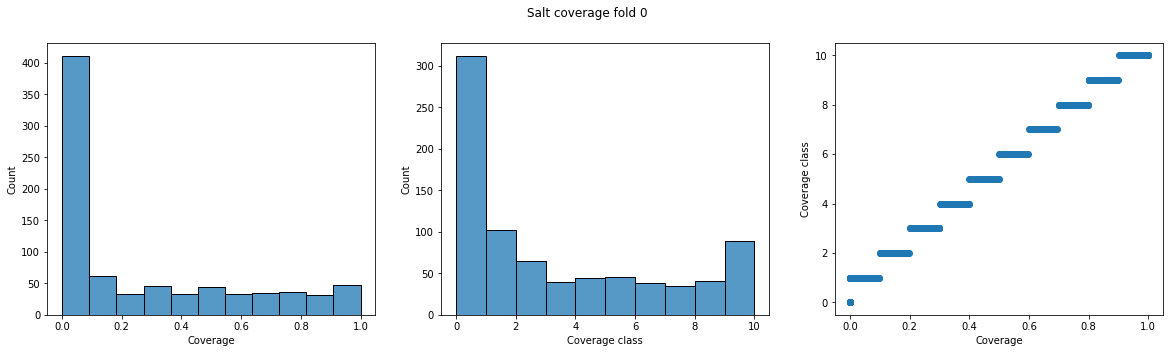

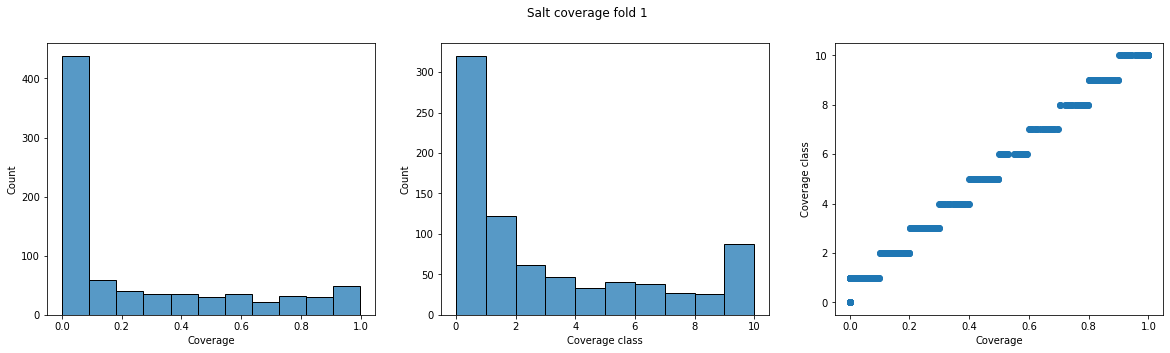

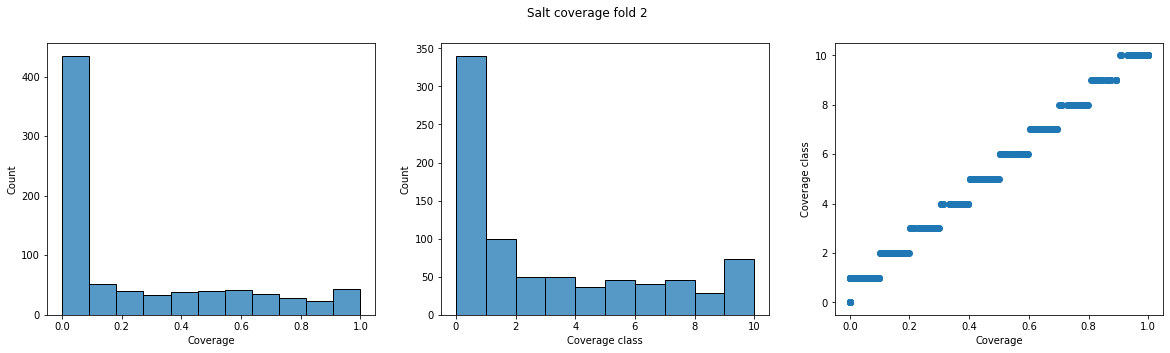

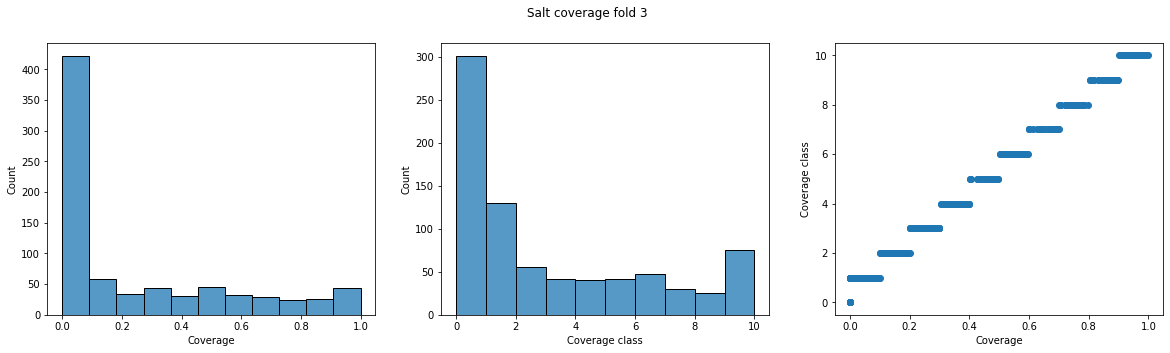

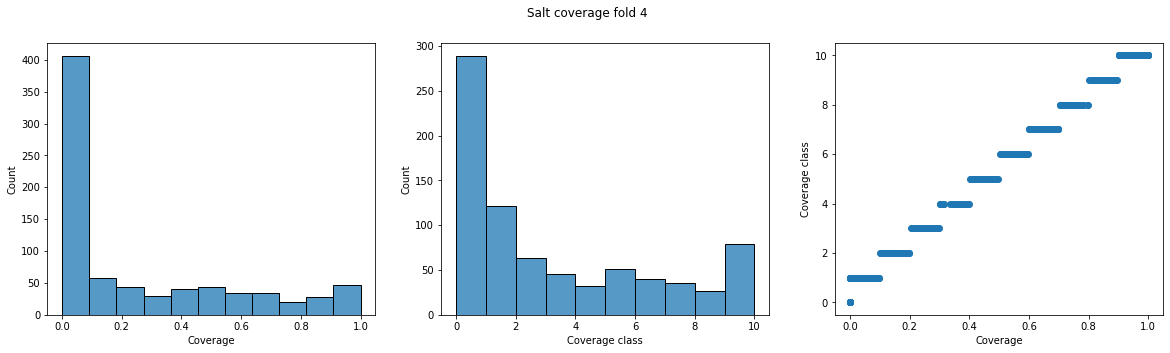

In [25]:
plot_coverage(train_df.loc[train_df.fold==0], suptitle='Salt coverage fold 0')
plot_coverage(train_df.loc[train_df.fold==1], suptitle='Salt coverage fold 1')
plot_coverage(train_df.loc[train_df.fold==2], suptitle='Salt coverage fold 2')
plot_coverage(train_df.loc[train_df.fold==3], suptitle='Salt coverage fold 3')
plot_coverage(train_df.loc[train_df.fold==4], suptitle='Salt coverage fold 4')

# Baseline

In [26]:
import os
os.chdir('../code') # chuyển đến thư mục chứa code để import các module
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # for plotting beautiful graphs

# Import Torch 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
from torch.utils.data import DataLoader, random_split
from torch.autograd import Variable
from torch import nn, optim

from data import TGSSaltDataset
from data.transforms import TGSTransform
from data.functional import collate_mask_fn
from data.transforms import TGSTransform, HShear
import albumentations as A

from utils.metrics import cal_mAP, cal_mIoU
from utils.viz import plot_mask_on_img

## Prepair Data

### Augmentation

Ta sẽ sử dụng albumentations làm thư viện chính cho augmentation. Các phép augmentation được sử dụng bao gồm:
* Horizontal flip
* Horizontal sheer
* Random Crop
* Random Rotate
* RandomBrightnessContrast

In [28]:
root_ds = '../dataset'
train_df = pd.read_csv(os.path.join(root_ds, 'folds.csv'), index_col='id').reset_index()
nonaug_ds = TGSSaltDataset(root_ds, train_df, transforms=None)

In [29]:
# Danh sách phép augmentation được sử dụng
augs_options = {
    'Original': A.NoOp(),
    'HFlip':A.HorizontalFlip(p=1.0),
    'HShear':HShear((0.19, 0.2), p=1.0),
    'RandomResizedCrop':A.RandomResizedCrop(width=101, height=101, p=1.0),
    'RandomRotate':A.Rotate(limit=(14, 15), p=1.0),
    'RandomBrightnessContrast':A.RandomBrightnessContrast(brightness_limit=0.1, p=1.0),
}

Plot ví dụ áp dụng các phép augmentation


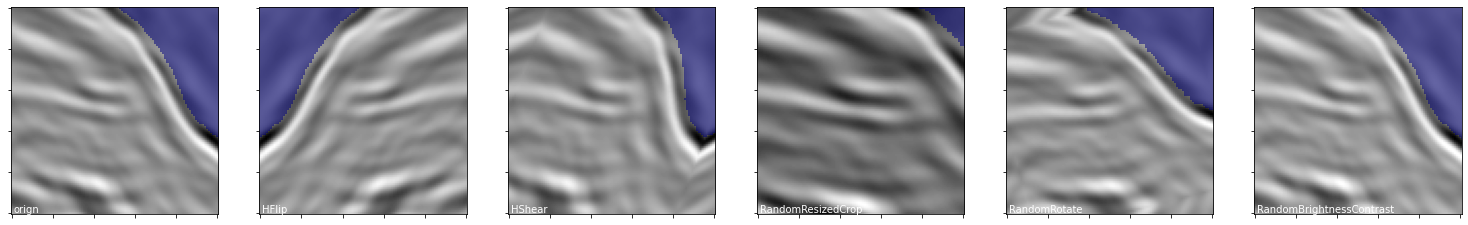

In [31]:
print("Plot ví dụ áp dụng các phép augmentation")
img, mask = nonaug_ds[3]
img = np.array(img)
mask = np.array(mask)
augs = {k: trans(image=img, mask=mask) for k, tran in augs_options}
plot_mask_on_img(axs[i + 1], aug['image'], aug['mask'])
fig, axs = plt.subplots(1, len(augs_options) + 1, figsize=(5 * len(augs_options) + 1, 5))
plot_mask_on_img(axs[0], img, mask)
axs[0].text(1, 100, 'orign', color="white")
for i, (k, trans) in enumerate(.items()):
    aug = 
    axs[i + 1].text(1, 100, k, color="white")

Ta sẽ thực hiện training sử dụng fold 0 làm valid set

In [33]:
root_ds = '../dataset'
cross_validation = True
fold_val_idx = 0

In [34]:
if not cross_validation:
    # DataFrame chứa toàn bộ train_id
    df = pd.read_csv(os.path.join(root_ds, 'train.csv'))
    df.drop('rle_mask', axis=1, inplace=True)
    df = pd.merge( df, pd.read_csv(os.path.join(root_ds, 'depths.csv')) , on='id', how='inner')
    total_sample = len(df.index)
    print('Total numper of sample:', total_sample)
    
    # Random split train/val=0.8/0.2
    train_size = int(0.8*total_sample)
    train_index, val_index = random_split(range(total_sample), [train_size, total_sample - train_size])
    
    train_df = df.loc[train_index.indices].reset_index()
    val_df = df.loc[val_index.indices].reset_index()
else:
    # DataFrame chứa toàn bộ train_id và đã được chia fold
    df = pd.read_csv(os.path.join(root_ds, 'folds.csv'), index_col='id')
    total_sample = len(df.index)
    print('Total numper of sample:', total_sample)

    train_df = df.loc[df.fold != 0].reset_index()
    val_df = df.loc[df.fold == 0].reset_index()

Total numper of sample: 4000


In [35]:
# Tạo dataset tương ứng với tập được chia
train_ds = TGSSaltDataset(root_ds, train_df, transforms=TGSTransform(augment=True))
val_ds = TGSSaltDataset(root_ds, val_df, transforms=TGSTransform(augment=False)) # Không augmentation cho valid set
print(len(train_ds), len(val_ds))

3190 810


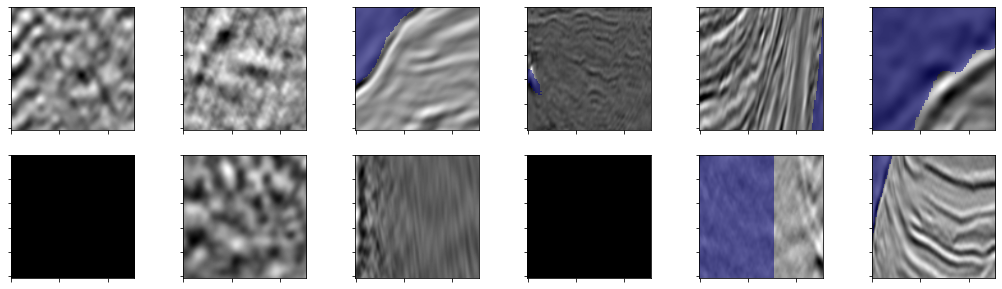

In [36]:
num_sample = 6
fig, axs = plt.subplots(2, num_sample, figsize=(3 * num_sample, 5))
for i in range(num_sample):
    img, mask = train_ds[i]
    img, mask = img.squeeze(), mask.squeeze()
    plot_mask_on_img(axs[0, i], img, mask > 0)
    img, mask = val_ds[i]
    img, mask = img.squeeze(), mask.squeeze()
    plot_mask_on_img(axs[1, i], img, mask > 0)

In [37]:
# Chuẩn bị dataloader
train_dl = DataLoader(train_ds, batch_size=16, num_workers=4, collate_fn=collate_mask_fn, shuffle=True, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=16, num_workers=4, collate_fn=collate_mask_fn, pin_memory=True)

# Define Network

<img src="../../images/unet_arch.png">

1. Sử dụng kiến trúc UNet cơ bản cho baseline model
    * Up sample bằng bilinear

In [43]:
from model.unet import DoubleConv, Down, Up, OutConv

In [44]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, num_filter1, num_down_stage, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, num_filter1)
        self.downs = [Down(num_filter1 * 2**i, num_filter1 * 2**(i + 1)) for i in range(num_down_stage - 1)]
        factor = 2 if bilinear else 1 # do bilinear khong half num feature
        self.downs.append(Down(num_filter1 * 2**(num_down_stage - 1), num_filter1 * 2**num_down_stage // factor))
        self.downs = nn.Sequential(*self.downs)

        self.ups = [Up(num_filter1 * 2**(num_down_stage - i) , num_filter1 * 2**(num_down_stage -1 - i) // factor, bilinear) for i in range(num_down_stage - 1)]
        self.ups.append(Up(num_filter1 * 2 , num_filter1 , bilinear))
        self.ups = nn.Sequential(*self.ups)
        self.outc = OutConv(num_filter1, n_classes)

    def forward(self, x):
        # Contrating path
        feature_blocks = [self.inc(x)]
        for down_module in self.downs:
            feature_blocks.append(down_module(feature_blocks[-1]))

        # Upsampling path
        resample_block = feature_blocks[-1]
        for i, up_module in enumerate(self.ups):
            resample_block = up_module(resample_block, feature_blocks[-i-2])
        
        # Segment
        logits = self.outc(resample_block)
        return logits

## Training Pipeline
1. Loss function: Pixel-wise BCE Loss
2. Adam optimizer (lr=1.5e-3), 25 epoch

In [41]:
from utils.metrics import cal_mAP
from torch.nn import functional as F
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [45]:
# Instantiate our model
model = UNet(1, 1, 64, 4)
model.to(device)
# Define our loss function
criterion =  F.binary_cross_entropy_with_logits
# Define the optimier
optimizer = optim.Adam(model.parameters(), lr=0.0015)

epochs = 25
steps = 0
print_every = 50
train_losses, test_losses = [], []

RuntimeError: CUDA error: all CUDA-capable devices are busy or unavailable

In [14]:
def train_one_epoch(train_dl, model, criterion, optimizer):
    running_loss = 0
    model.train()
    for images, labels in train_dl:
        images, labels = images.to(device), labels.to(device)
        # Prevent accumulation of gradients
        optimizer.zero_grad()
        
        # Make predictions
        log_ps = model(images)
        
        bs = images.size(0)
        loss = criterion(log_ps.view(bs, -1, 1), labels.view(bs, -1, 1))
        #backprop
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    return running_loss / len(train_dl)

def eval_one_epoch(val_dl, model, criterion):
    model.eval()
    test_loss = 0
    accuracy = 0
    with torch.no_grad():
        for images, labels in val_dl:
            images, labels = images.to(device), labels.to(device)
            log_ps = model(images)
            bs = images.size(0)
            test_loss += criterion(log_ps.view(bs, -1, 1), labels.view(bs, -1, 1))

            mAP = cal_mAP(log_ps.detach(), labels.detach())
            accuracy += mAP
    return test_loss / len(val_dl), accuracy / len(val_dl)

def test_step(model, images, thress=0.5):
    images = images.to(device)
    model.eval()
    log_ps = model(images)
    return log_ps > thress

In [16]:
!mkdir -p ../params/basics
torch.save(model.state_dict(), '../params/baseline/fold_{:02d}.pth'.format(fold_val_idx))

# Evaluation

In [38]:
model = UNet(1, 1, 64, 4).load_state_dict(torch.load('../params/basics/fold_00.pth'))

NameError: name 'UNet' is not defined

In [ ]:
ds_test = TGSSaltDataset(root_ds, test_df, image_set='test', transforms=TGSTransform(augment=False))
test_dl = DataLoader(self.ds_test,
                          shuffle=False,
                          batch_size=self.hparams.batch_size,
                          num_workers=self.hparams.num_workers,
                          pin_memory=True)

In [ ]:
preds_test_upsampled = []
model.eval()
model.cuda()
with torch.no_grad():
    for images in test_dl:
        pred_masks = model.test_step(images.cuda(), 0)
        preds_test_upsampled.append(pred_masks)
preds_test = torch.cat(preds_test_upsampled, dim=0).unsqueeze(1)
np.save('../predictions/baseline/fold_00')

In [ ]:
preds_101 = torch.zeros(preds_test.shape[0], 101, 101)
for idx in range(preds_test.shape[0]):
    preds_101[idx] = resize(preds_test[idx], (101, 101))
print(preds_101.shape)
preds_101 = preds_101.cpu().numpy().round().astype(int)

In [ ]:
num_sample = 10
fig, axs = plt.subplots(1, num_sample, figsize=(5 * num_sample, 5))
for i in range(num_sample):
    offset = 100
    img = cv2.resize(dm.ds_test[i + offset].squeeze().cpu().numpy(), dsize=(101, 101))
    mask = preds_101[i + offset]
    plot_mask_on_img(axs[i], img, mask)

In [ ]:
from utils import rle_encode

In [63]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns =['rle_mask']
sub.to_csv('submission.csv')